In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
%matplotlib inline

data_path = '/home/asceta/Projects/Alerce/AlerceDHtest/datasets/ZTF'

#with open('/home/asceta/LRPpaper/datasets/ZTF/reals.pkl', 'rb') as f:
#    reals = pkl.load(f)
#with open('/home/asceta/LRPpaper/datasets/ZTF/bogus.pkl', 'rb') as f:
#    bogus = pkl.load(f)
    
#print('Number of reals: %d' %len(reals))
#print('Number of bogus: %d' %len(bogus))

In [2]:
path = data_path+'/broker_reals.json'
with open(path, "r") as f:
        dataset = json.load(f)
        


In [3]:
type(dataset)
dataset.keys()

dict_keys(['query_result'])

In [4]:
len(dataset['query_result'])

7410

In [5]:
dataset['query_result'][0].keys()

dict_keys(['_id', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])

In [6]:
dataset['query_result'][0]['candidate']['fid']

2

In [7]:
psf_data_dict={"g":{}, "r":{}, "i":{}}

In [8]:
for channel in psf_data_dict.keys():
    psf_data_dict[channel]={"n_alerts":{}, "stamp":{}, "jd":{}, 'mean_stamps':{}, 'mean_stamp_masked':{}}

In [9]:
#n_alerts = {}
#stamp_dict = {}
#FWHM_dict = {}
all_fwhm = []
filters_ls = list(psf_data_dict.keys())
for alert in dataset["query_result"]:
    fwhm = alert["candidate"]["fwhm"]
    jd = alert["candidate"]["jd"]
    fid = alert["candidate"]["fid"]
    all_fwhm.append(fwhm)
    stamp = alert['cutoutDifference']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data

    if fwhm in psf_data_dict[filters_ls[fid-1]]['n_alerts'].keys():
        psf_data_dict[filters_ls[fid-1]]['n_alerts'][fwhm] += 1
        psf_data_dict[filters_ls[fid-1]]['stamp'][fwhm].append(img)
        psf_data_dict[filters_ls[fid-1]]['jd'][fwhm].append(jd)
    else:
        psf_data_dict[filters_ls[fid-1]]['n_alerts'][fwhm] = 1
        psf_data_dict[filters_ls[fid-1]]['stamp'][fwhm] = [img,]
        psf_data_dict[filters_ls[fid-1]]['jd'][fwhm] = [jd,]

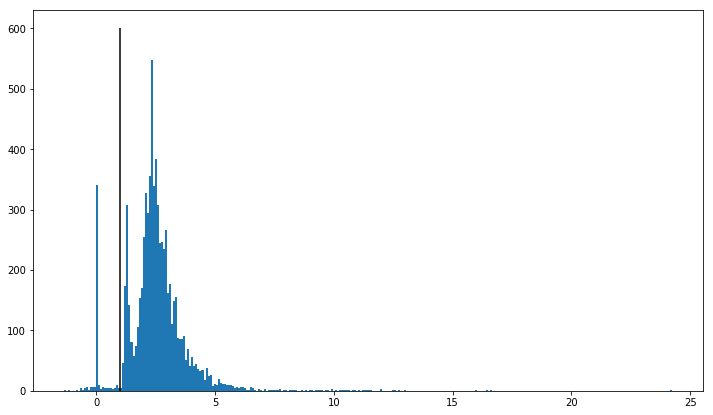

In [10]:
#fwhm hist
plt.figure(figsize=(12,7))
plt.hist(all_fwhm, bins=300)
plt.vlines(x=1, ymin=0, ymax=600)
plt.show()

(19, 21, 21)


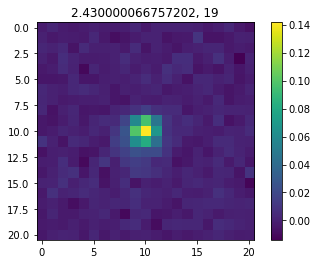

(16, 21, 21)


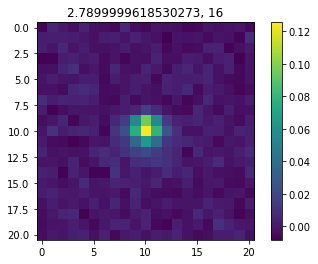

(11, 21, 21)


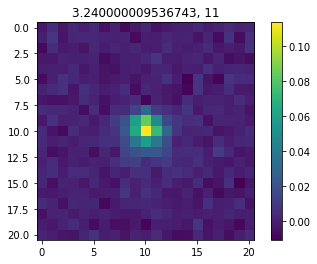

In [11]:
#plot stamps
estimated_psfs = []
channel = 'g'
n_alerts = psf_data_dict[channel]['n_alerts']
stamp_dict = psf_data_dict[channel]['stamp']
for j, fw in enumerate(n_alerts.keys()):
    if fw>1 and fw<12 and n_alerts[fw] >= 10:
        aux_stamp_dict = stamp_dict[fw][:]
        for i, s in enumerate(aux_stamp_dict):
            aux_stamp_dict[i] = np.nan_to_num(s)[21:42, 21:42]
            aux_stamp_dict[i] = aux_stamp_dict[i]/np.sum(aux_stamp_dict[i])
        aux_stamp_dict = np.stack(aux_stamp_dict)
        print(aux_stamp_dict.shape)
        psf = np.mean(aux_stamp_dict, axis=0)
        plt.imshow(psf)
        plt.colorbar()
        plt.title(str(fw)+", "+str(n_alerts[fw]))
        plt.show()
    if j == 8:
        break

In [12]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    radius = np.round(radius)
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [13]:
#calculate mean stamp and masked mean
n_sigmas = 4
for channel in filters_ls:
    n_alerts = psf_data_dict[channel]['n_alerts']
    stamp_dict = psf_data_dict[channel]['stamp']
    for j, fw in enumerate(n_alerts.keys()):
        if fw>1 and fw<12 and n_alerts[fw] >= 10:
            aux_stamp_dict = stamp_dict[fw][:]
            for i, s in enumerate(aux_stamp_dict):
                aux_stamp_dict[i] = np.nan_to_num(s)[21:42, 21:42]
                aux_stamp_dict[i] = aux_stamp_dict[i]/np.sum(aux_stamp_dict[i])
            aux_stamp_dict = np.stack(aux_stamp_dict)
            #print(aux_stamp_dict.shape)
            psf = np.mean(aux_stamp_dict, axis=0)
            
            #mask
            mask = createCircularMask(21,21,radius=n_sigmas*(fw/2.35482))
            masked_psf = mask*psf
            
            #append mean stamp
            psf_data_dict[channel]['mean_stamps'][fw] = psf
            psf_data_dict[channel]['mean_stamp_masked'][fw] = masked_psf
            #if fw in psf_data_dict[channel]['mean_stamps'].keys():
                #psf_data_dict[channel]['mean_stamps'][fw].append(psf)
            #else:
                #psf_data_dict[channel]['mean_stamps'][fw] = [psf,]

            #append mask
            #if fw in psf_data_dict[channel]['mean_stamp_masked'].keys():
            #    psf_data_dict[channel]['mean_stamp_masked'][fw].append(masked_psf)
            #else:
                #psf_data_dict[channel]['mean_stamp_masked'][fw] = [masked_psf,]

/home/asceta/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


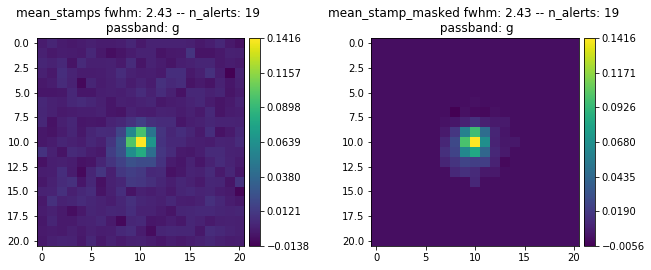

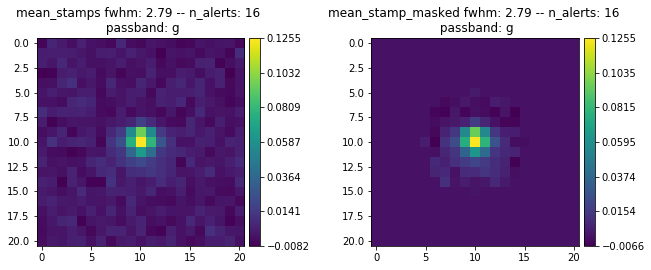

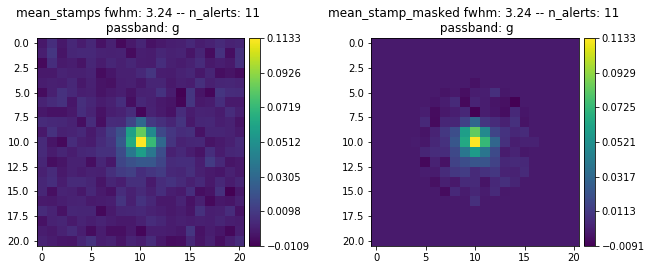

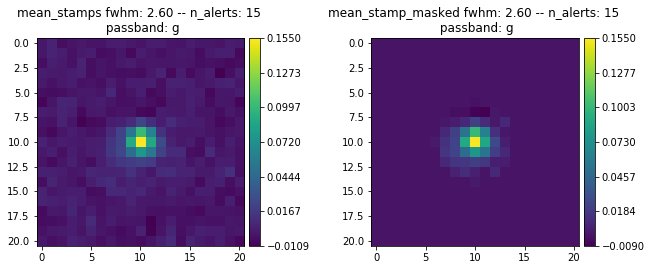

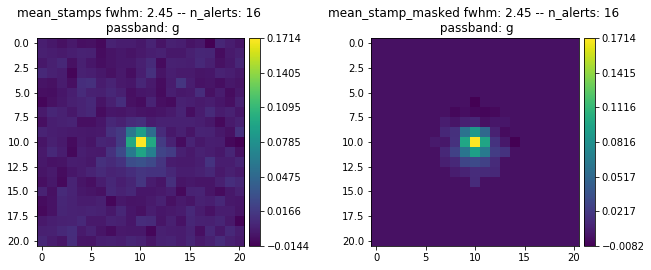

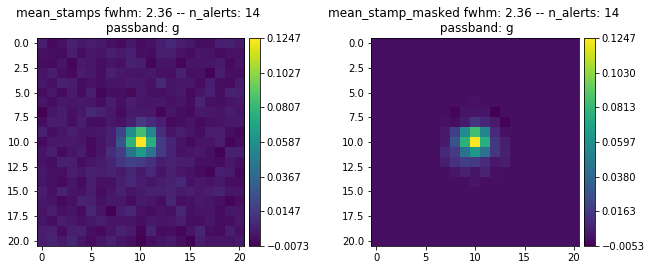

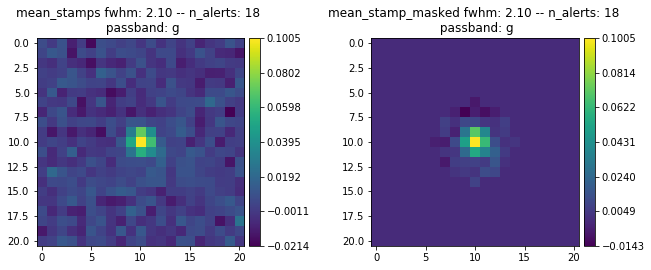

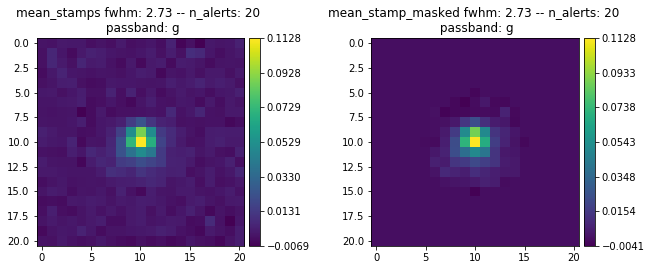

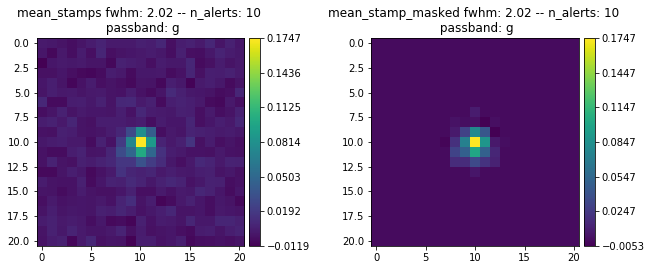

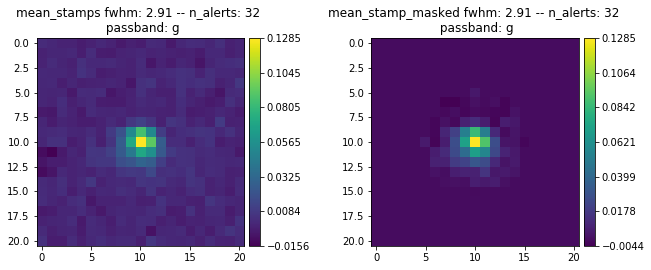

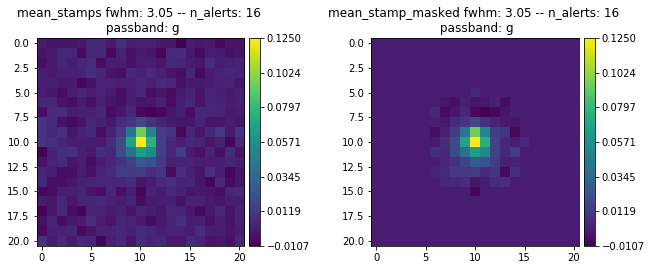

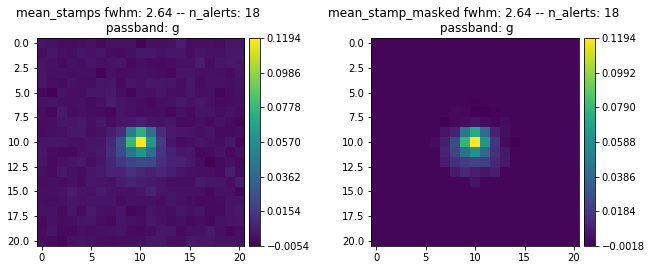

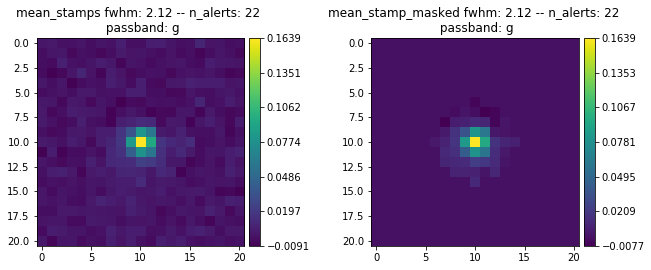

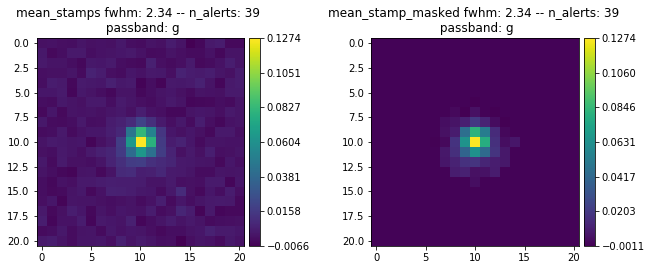

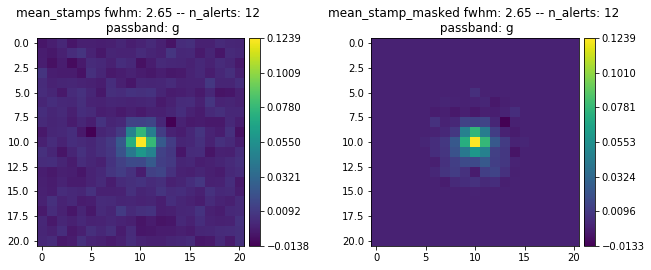

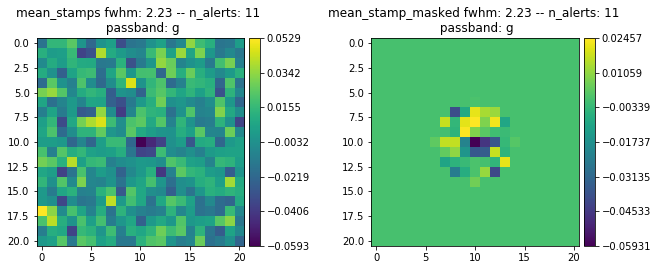

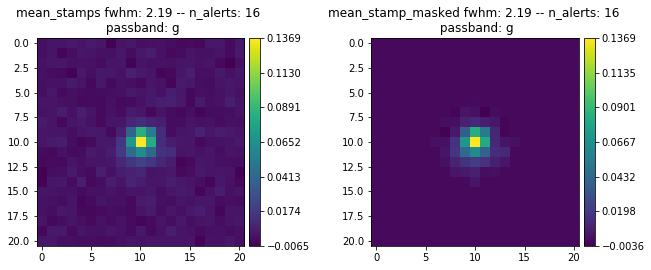

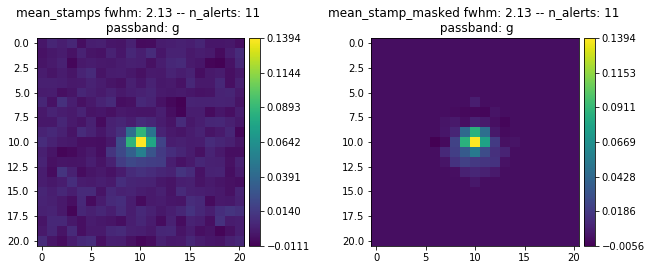

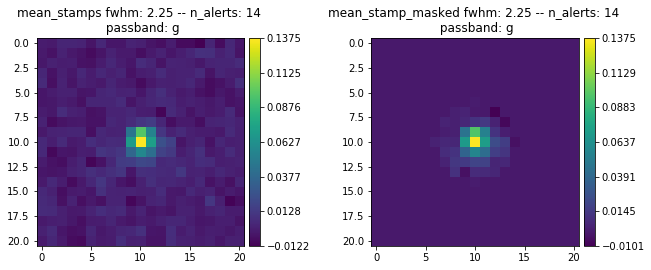

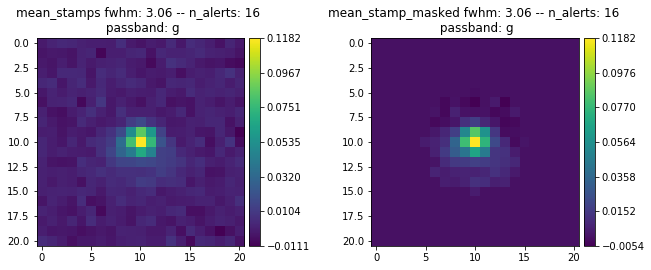

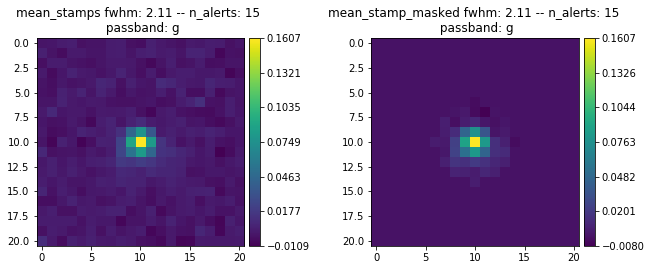

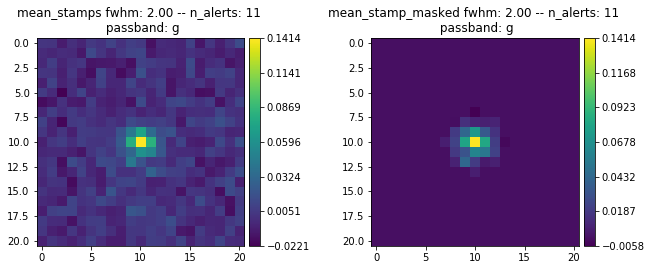

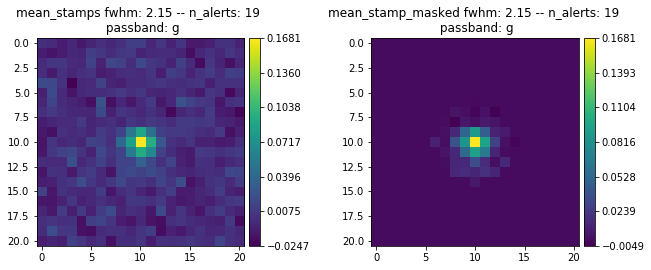

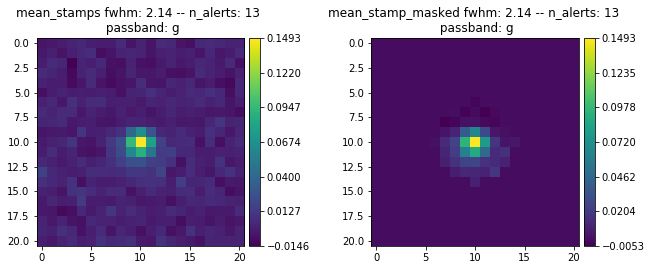

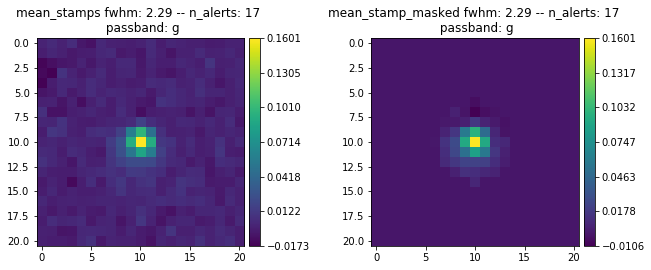

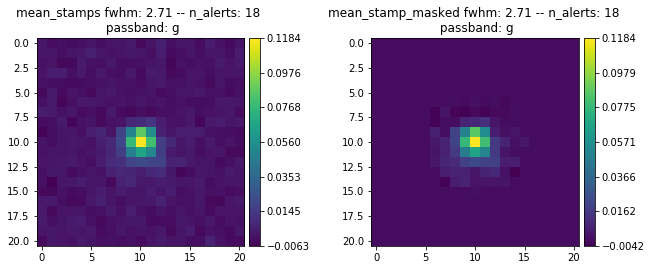

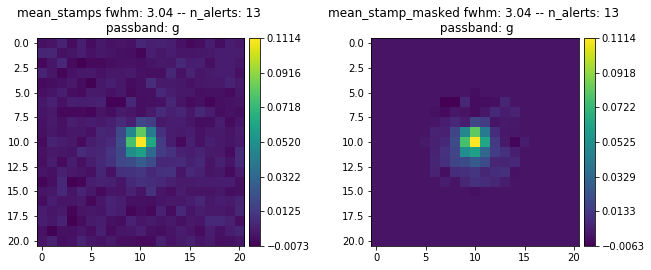

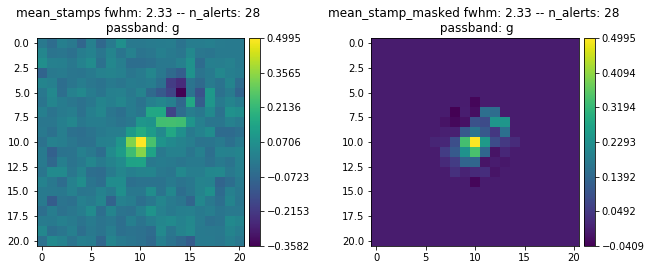

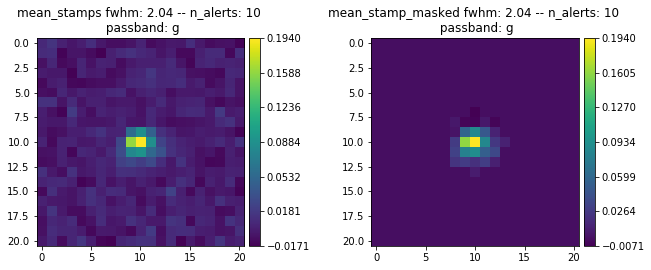

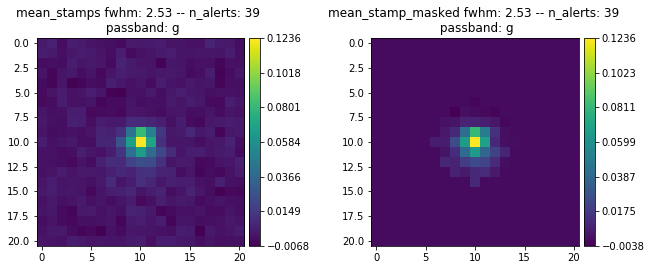

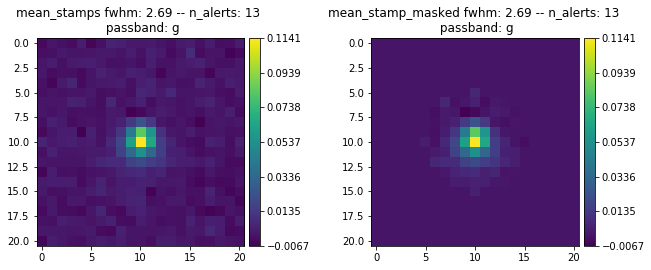

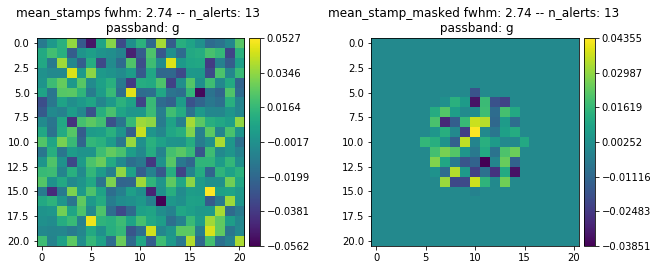

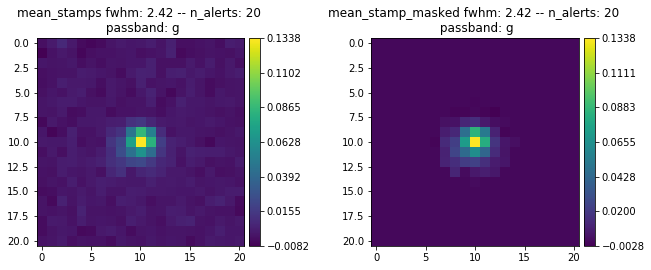

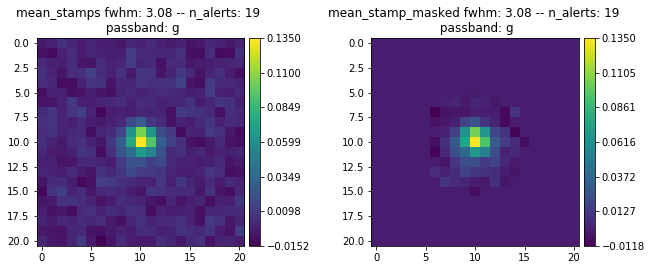

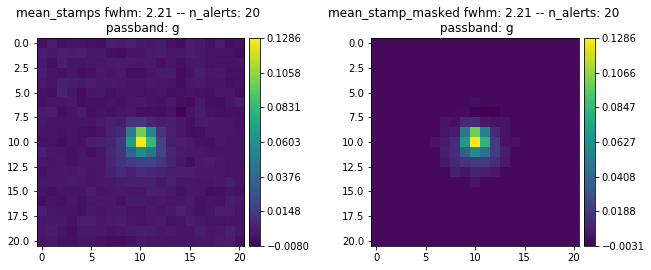

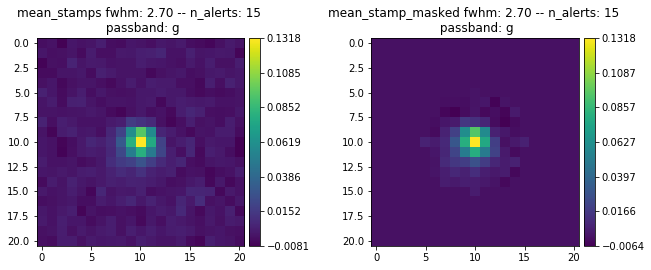

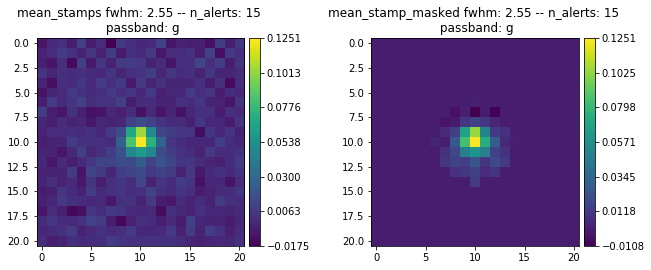

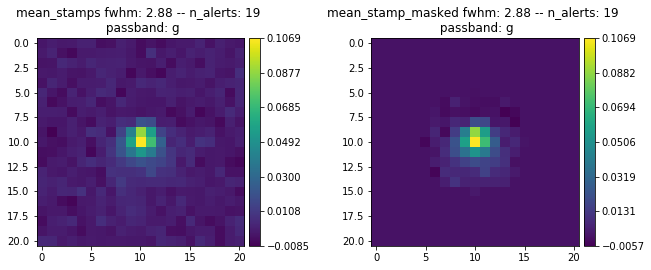

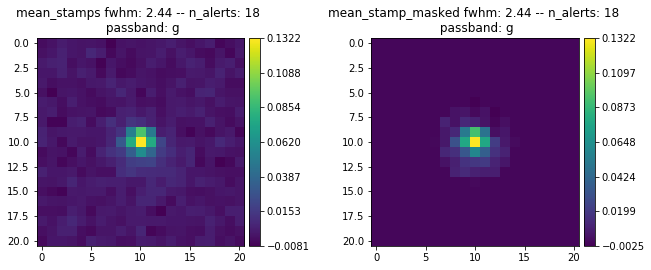

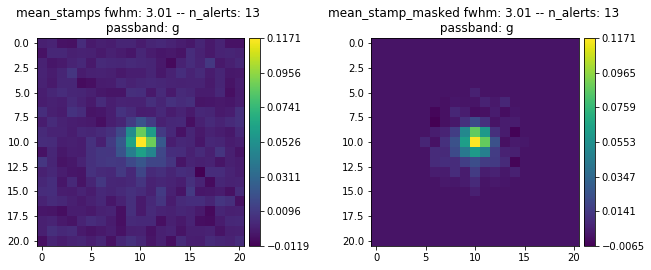

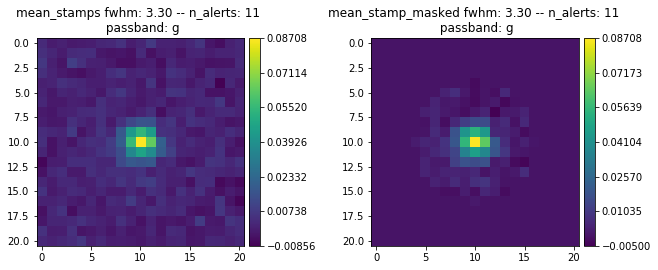

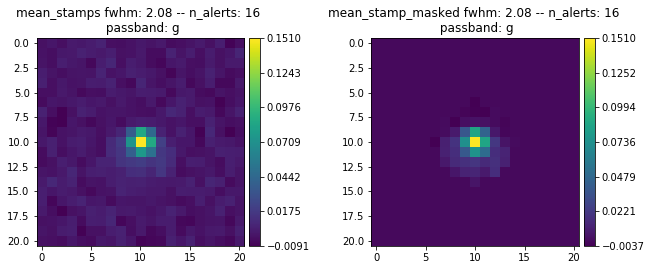

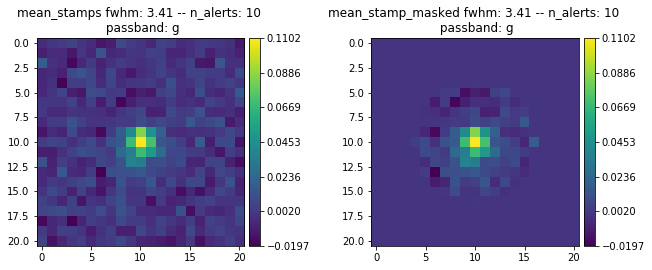

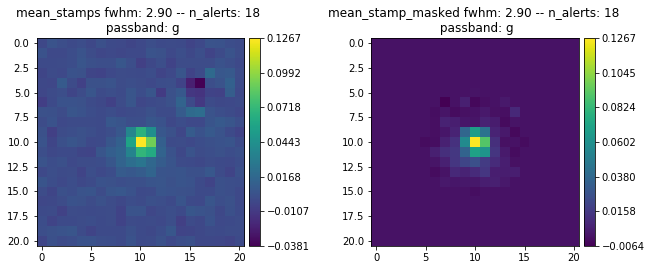

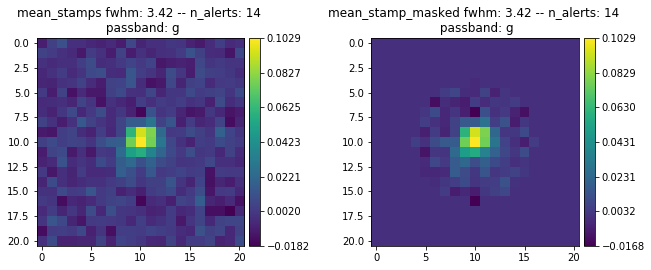

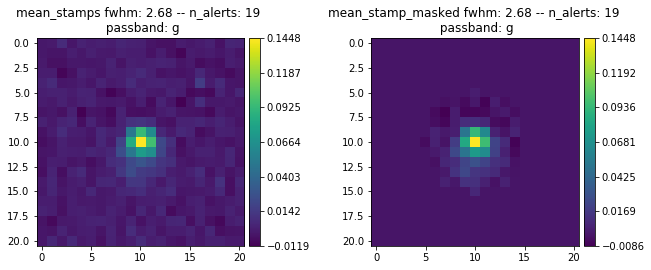

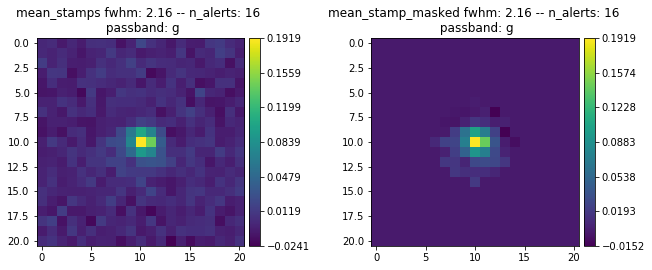

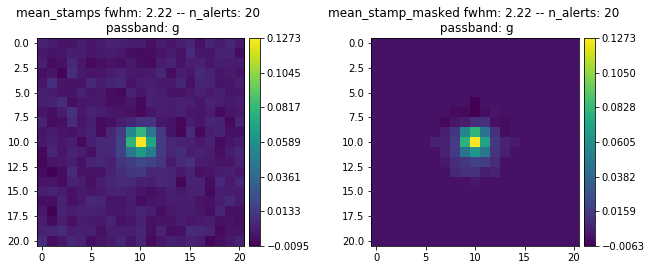

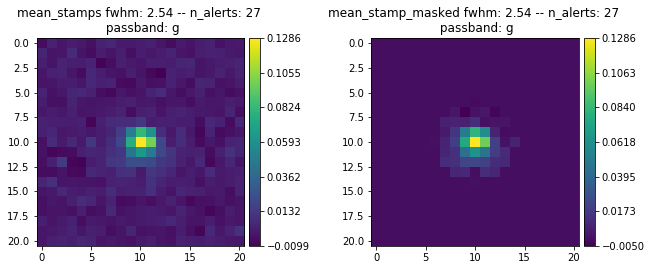

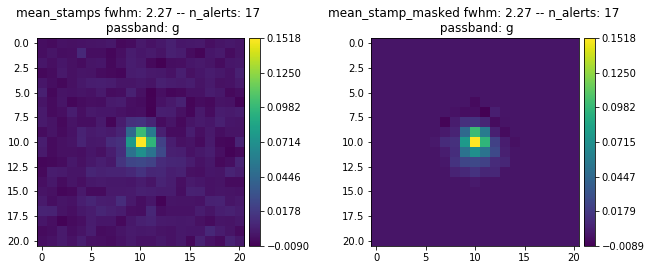

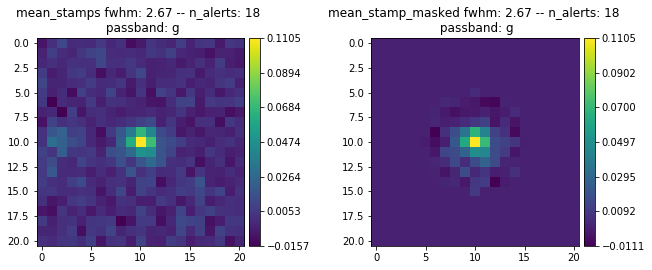

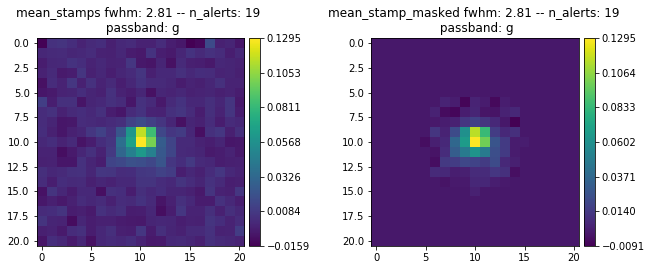

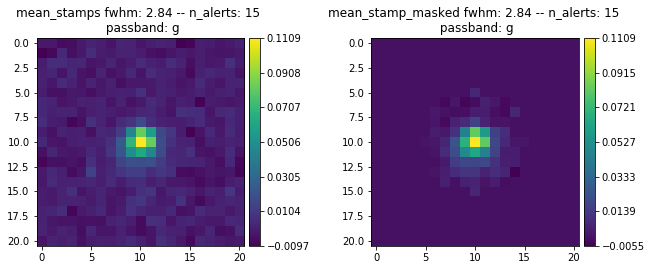

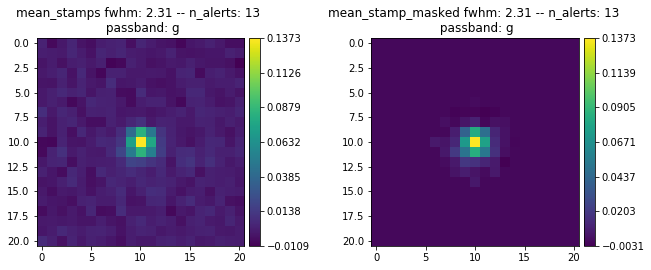

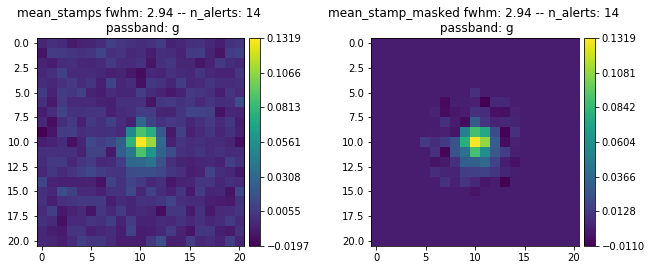

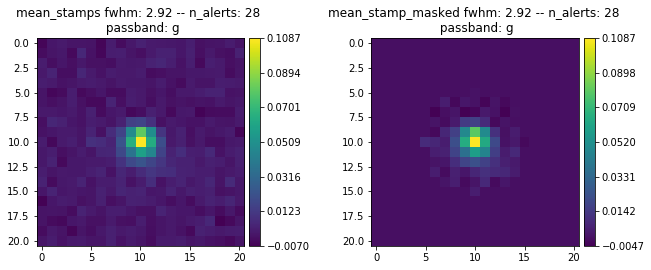

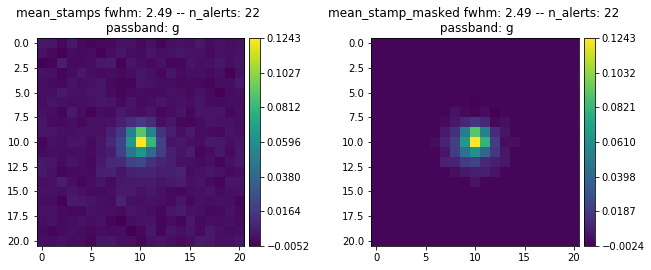

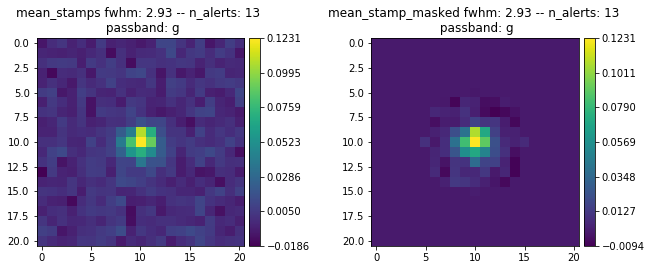

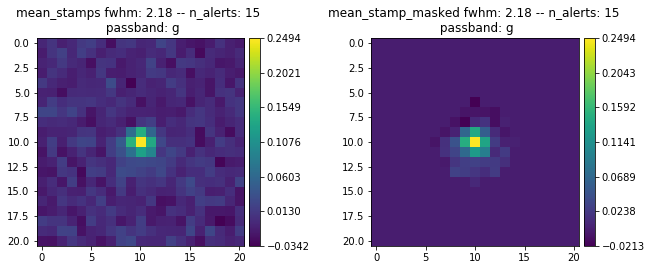

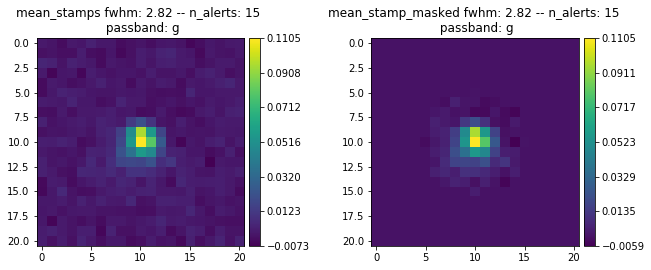

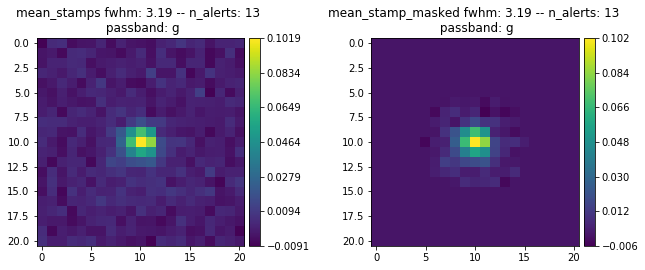

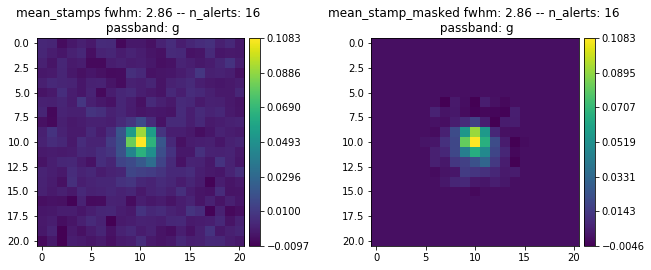

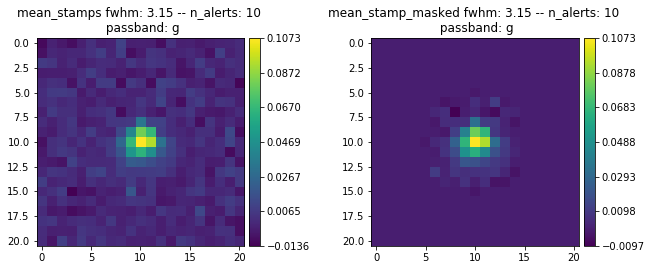

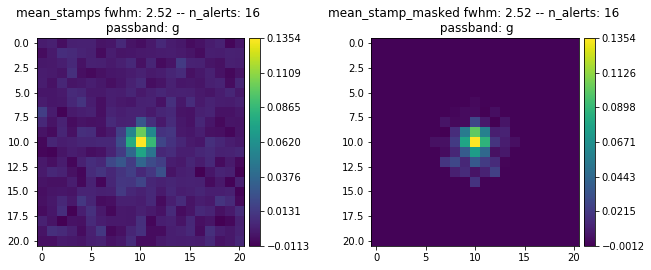

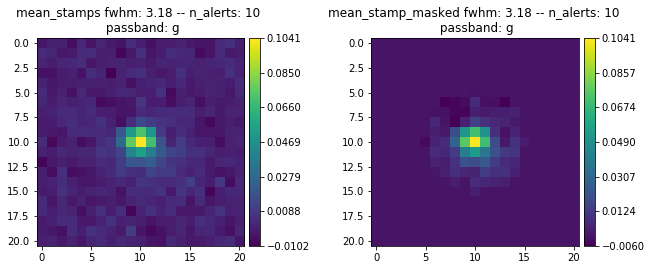

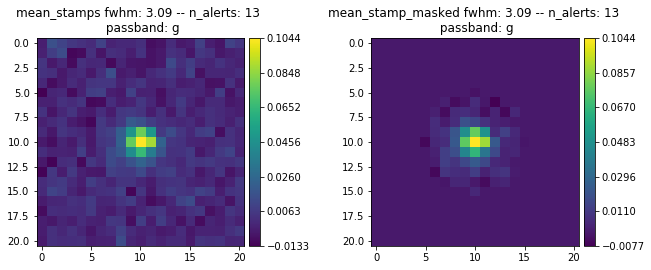

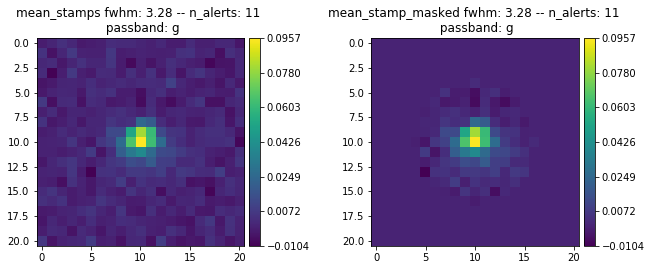

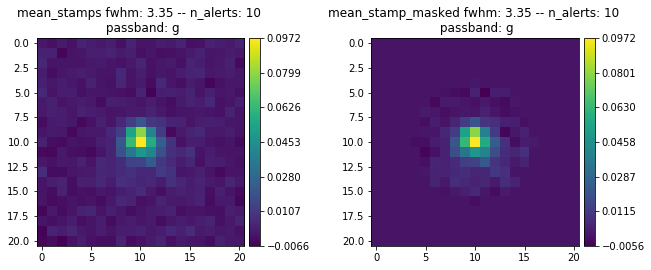

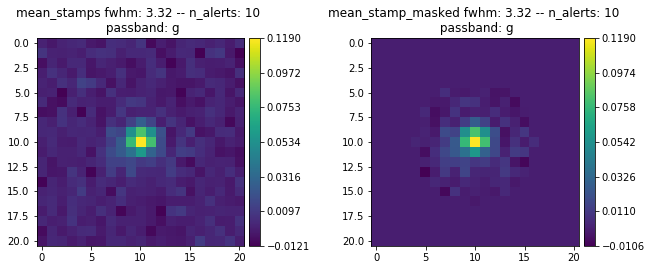

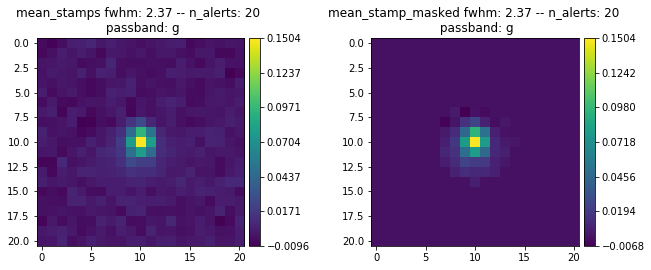

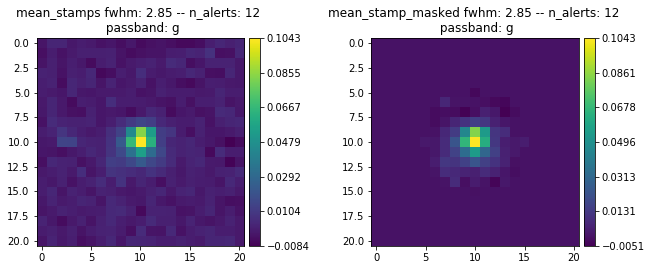

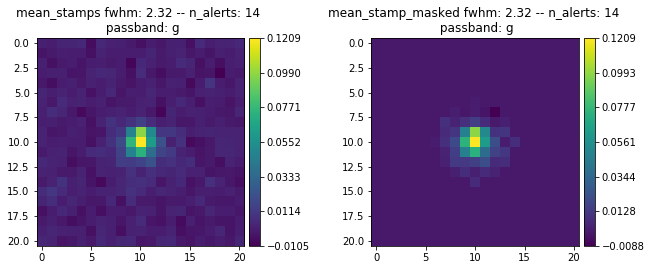

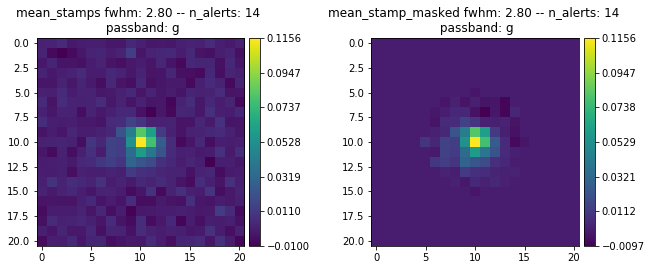

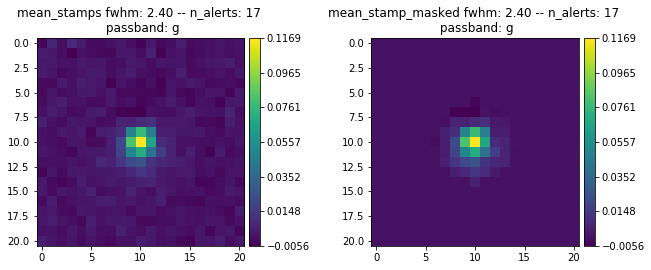

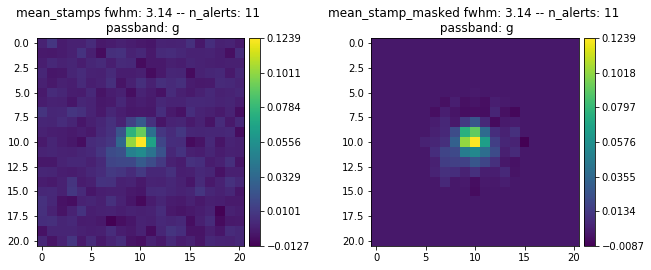

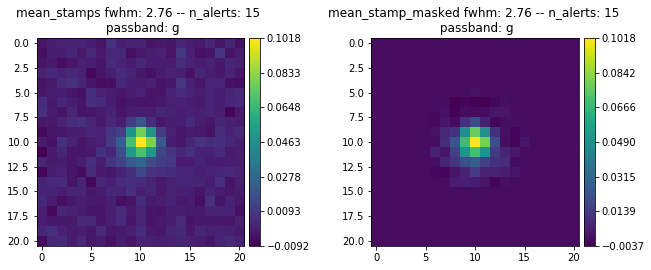

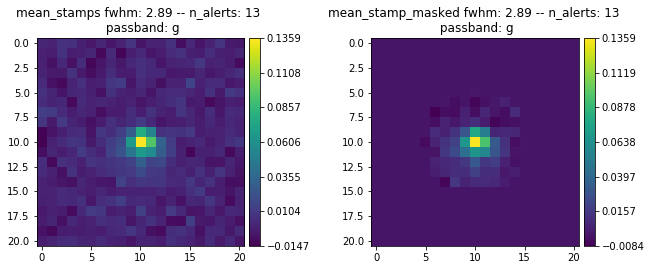

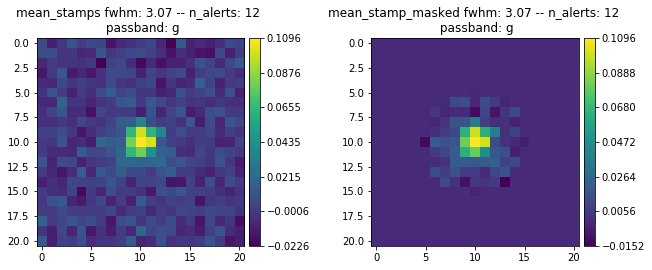

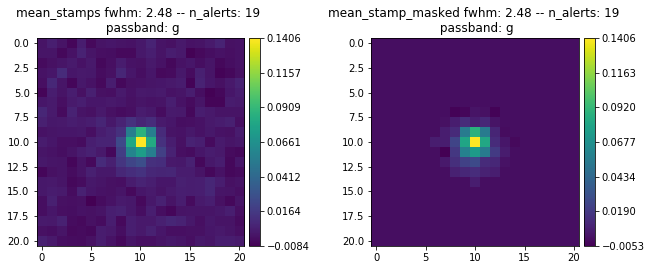

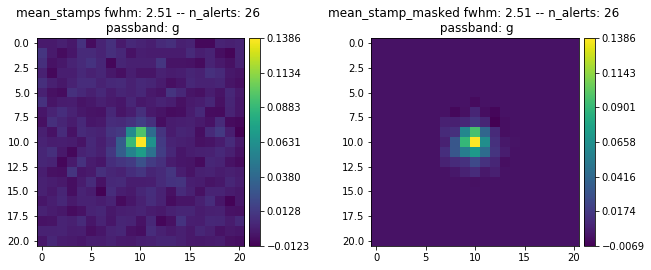

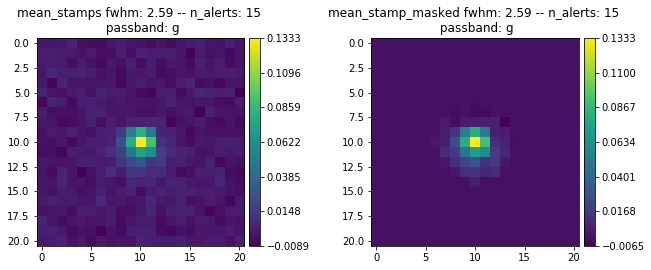

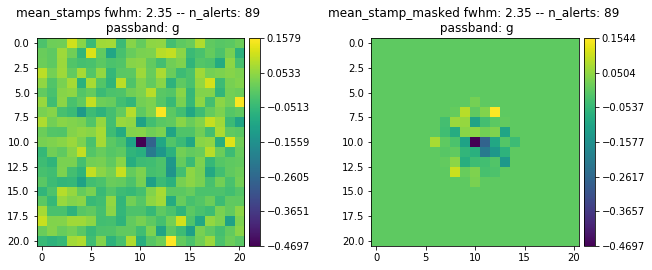

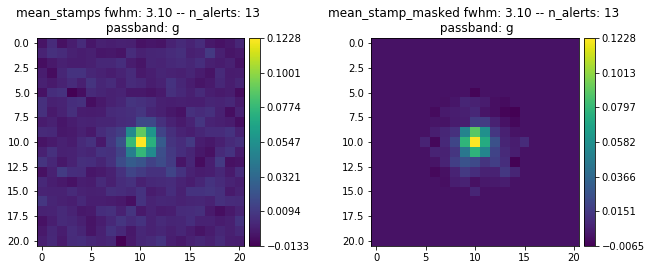

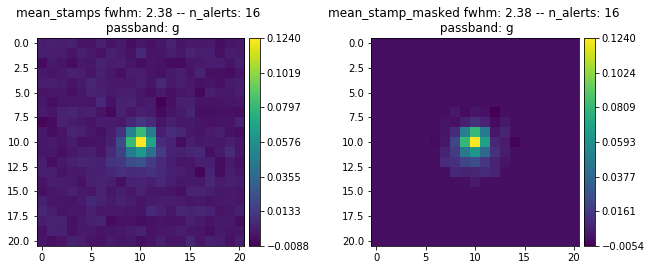

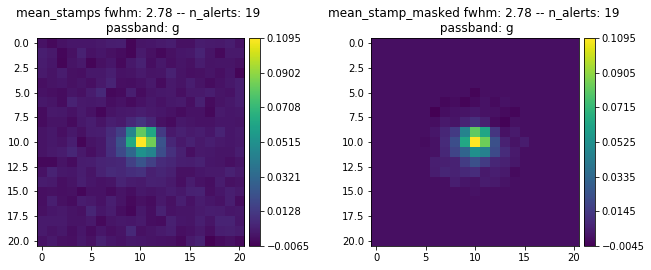

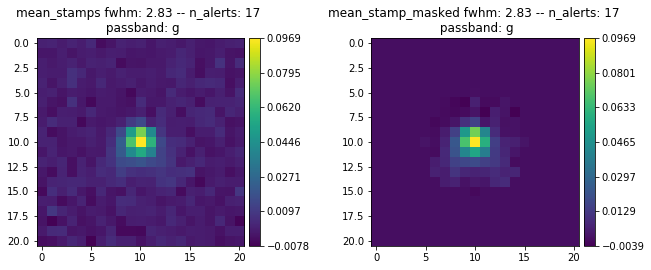

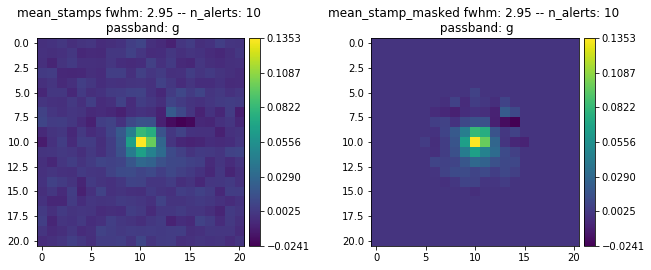

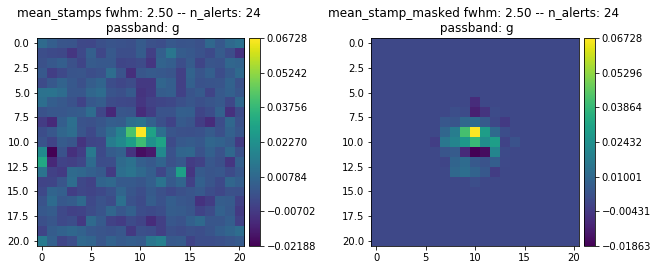

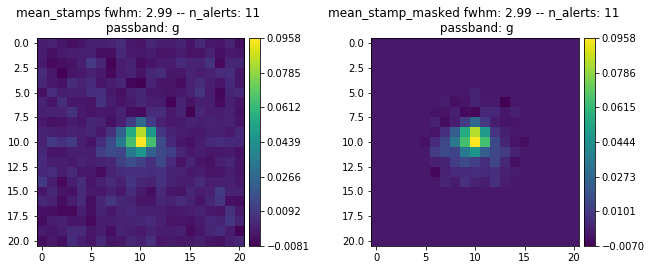

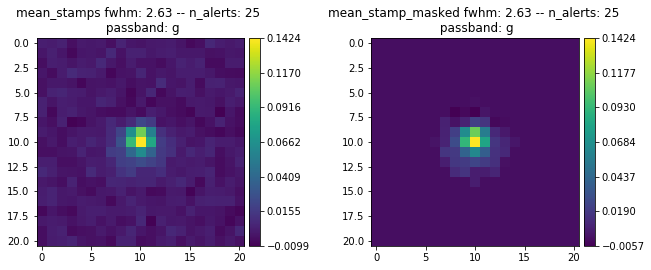

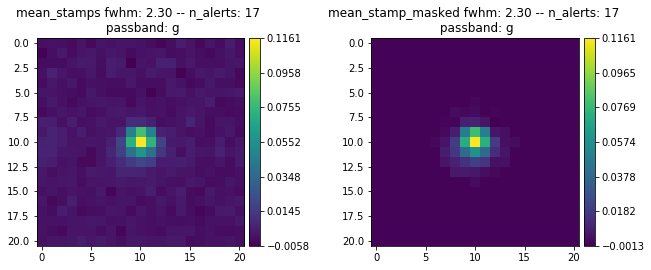

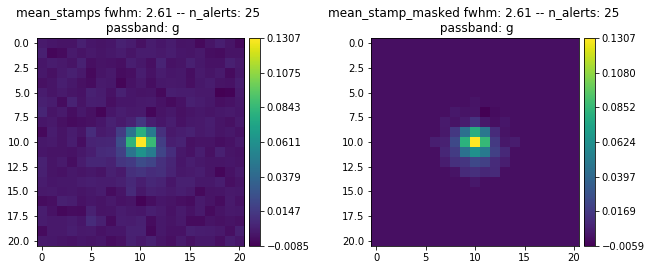

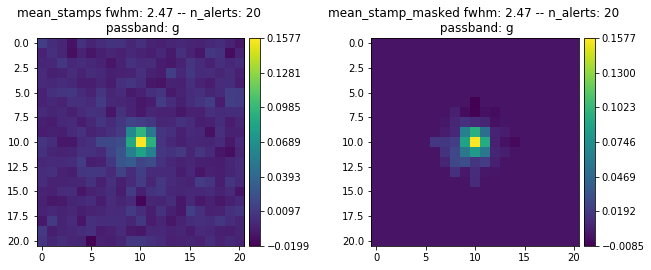

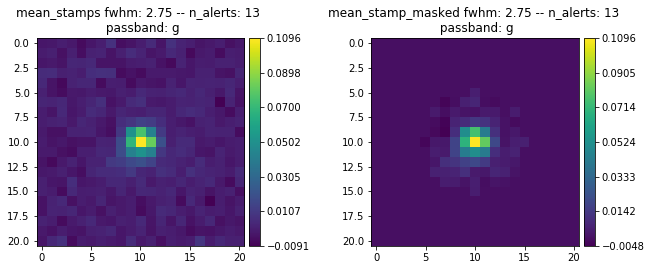

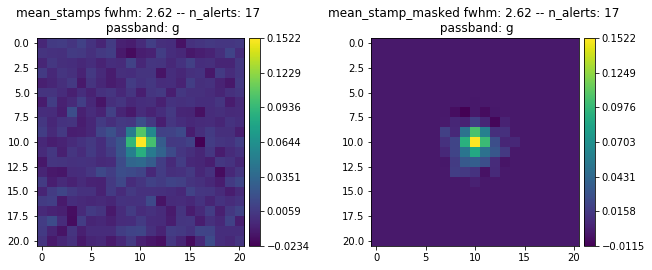

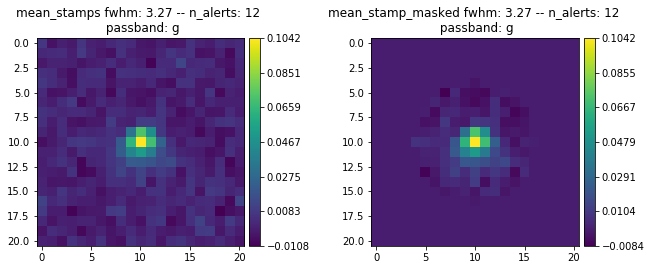

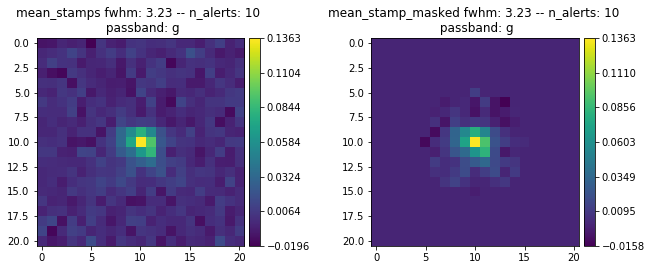

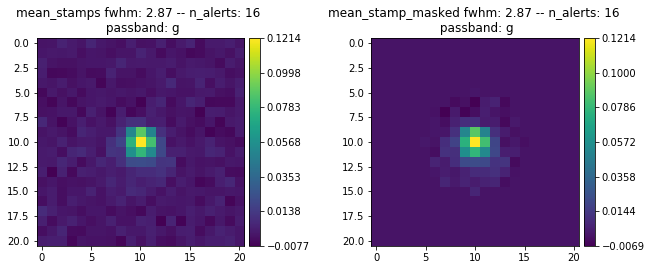

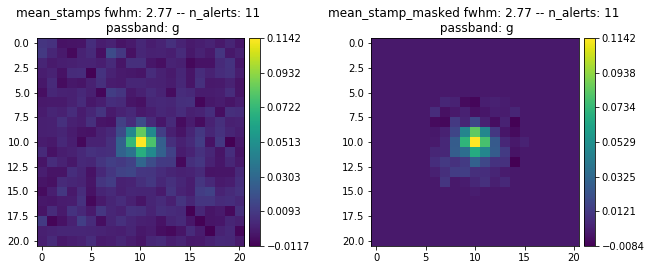

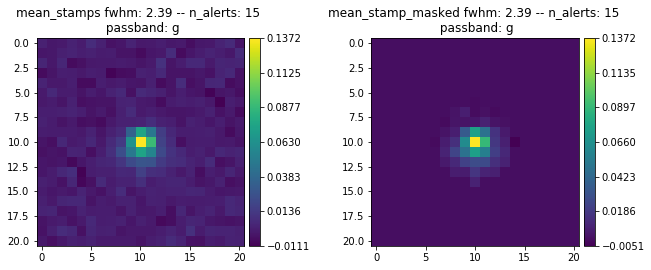

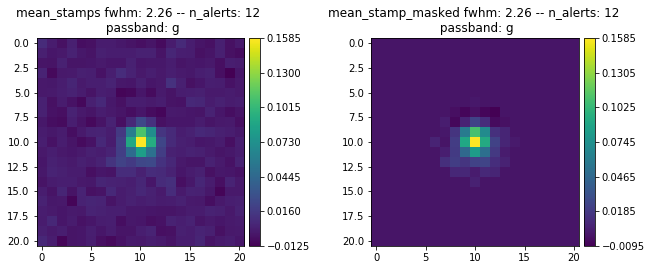

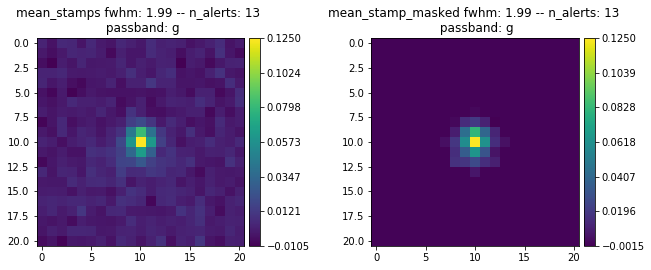

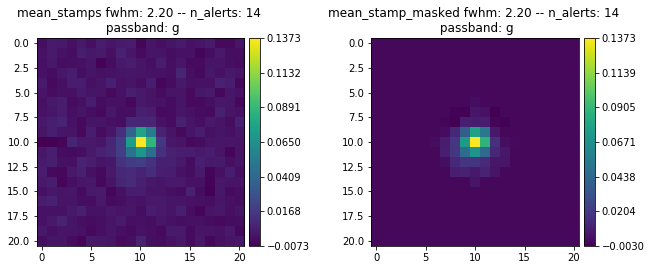

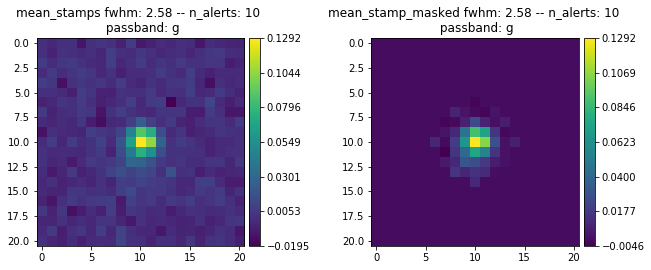

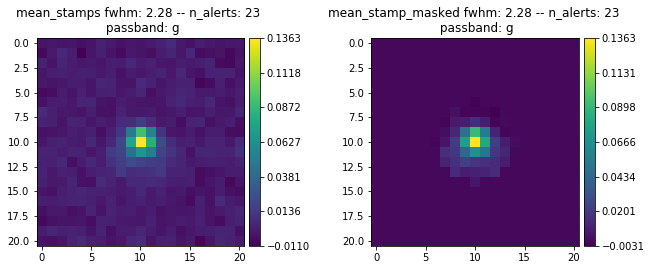

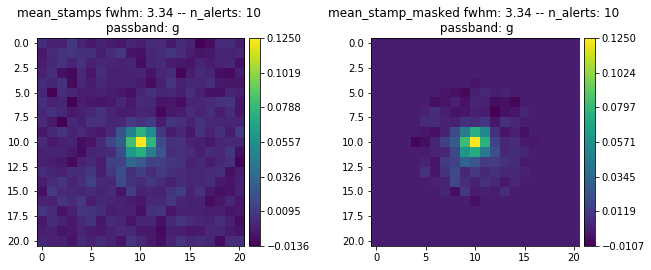

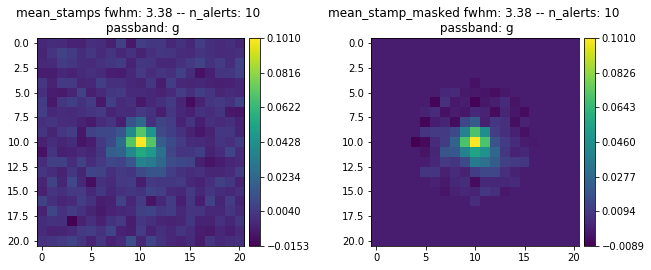

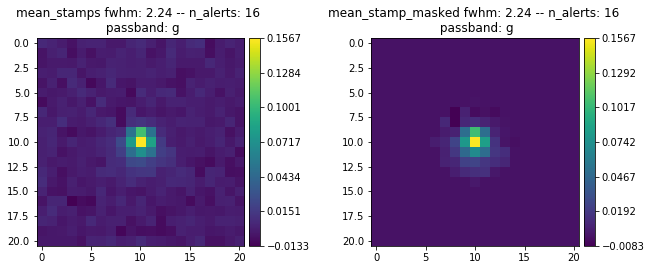

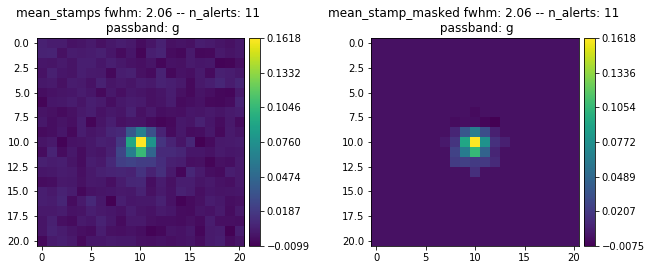

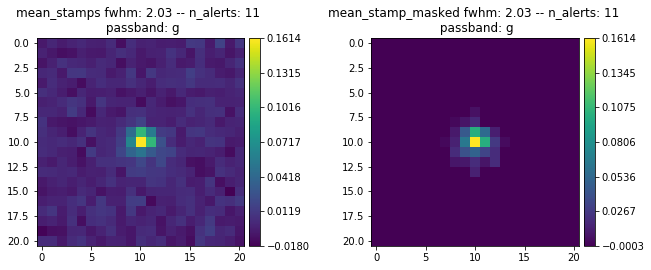

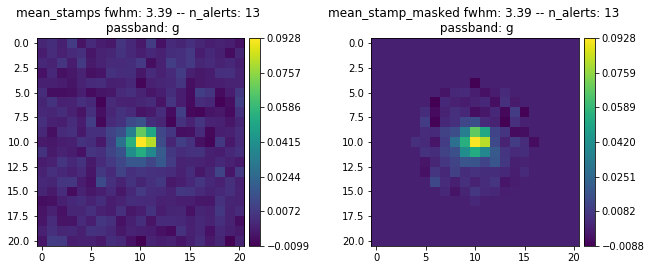

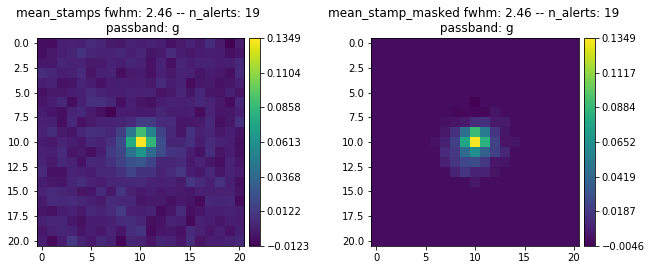

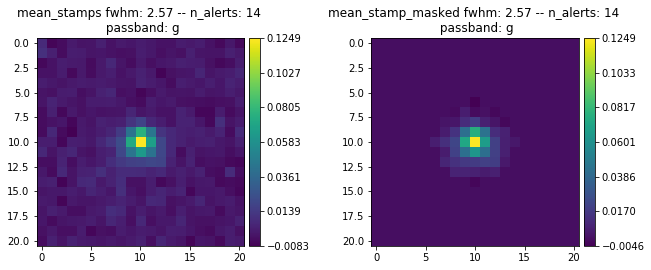

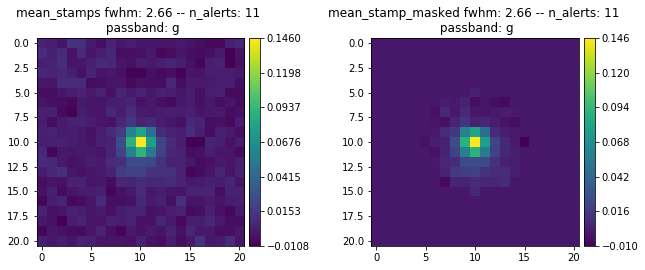

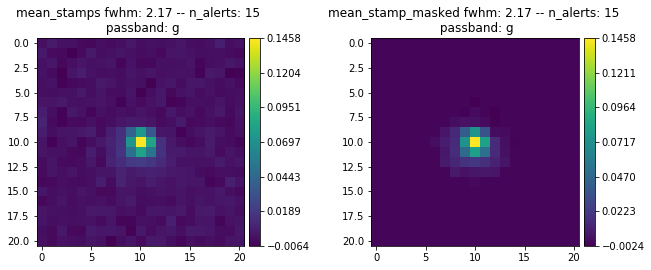

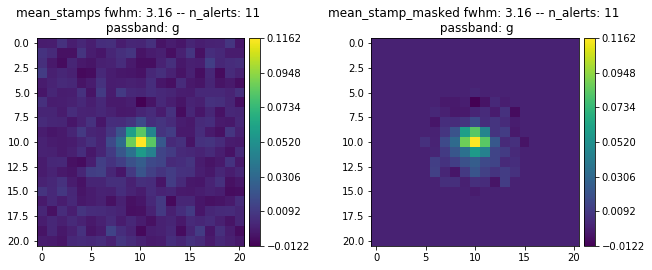

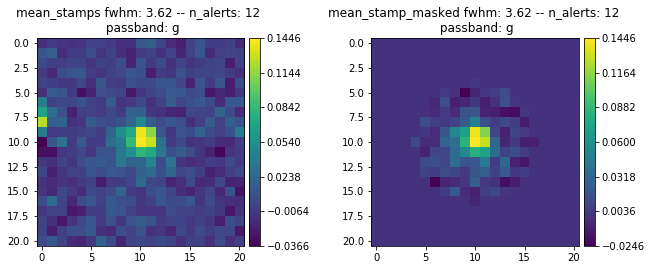

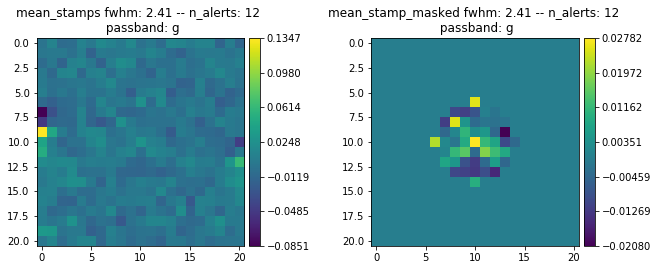

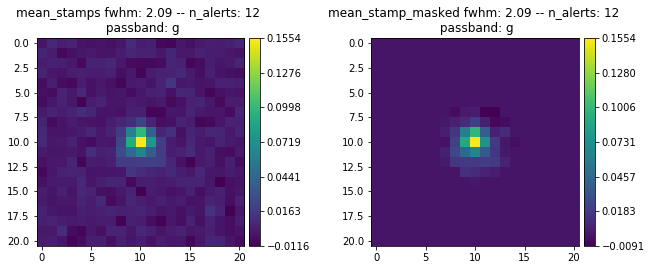

In [14]:
#ploting stamps and masks
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
channel = 'g'
samples = 1000
titles = ["mean_stamps", "mean_stamp_masked"]
for j, fwhm in enumerate(psf_data_dict[channel]['mean_stamps']):
    fig, ax = plt.subplots(nrows=1, ncols=len(titles), figsize=(int(len(titles)*5), 5))
    plt.subplots_adjust(wspace = 0.5)
    for i in range(len(ax)):
        sample=psf_data_dict[channel][titles[i]][fwhm]
        img = ax[i].imshow(sample)
        #fig.colorbar()

        ax[i].set_title("%s fwhm: %.2f -- n_alerts: %i \n passband: %s" % (titles[i], fwhm, 
                                                                           psf_data_dict[channel]['n_alerts'][fwhm],
                                                                          channel))
        divider = make_axes_locatable(ax[i])
        width = axes_size.AxesY(ax[i], aspect=1./20)
        pad = axes_size.Fraction(0.5, width)
        cax = divider.append_axes("right", size=width, pad=pad)
        v = np.linspace(sample.min(), sample.max()*0.99999, 7, endpoint=True)
        plt.colorbar(img, cax=cax, ticks=v)
    #fig.colorbar(img)

    if j==samples:
        break